In [0]:
import pandas as pd
import numpy as np
import json
import csv
import requests
from collections import Counter
import nltk
import pandas as pd
import re as regex
from time import time
import gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt




In [28]:
#NLTK
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install ekphrasis


     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 184kB 10.0MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82843 sha256=4cee22fd50c2fe3cbebeae2b8d8cd35a82e4b09d692fa15e704ac7bac8f53fa7
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=27653e7e783482987f0300ac35ec53c6debfbf62c1287c497c6b9b0ae58f3fdb
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ekphrasis ftfy


In [0]:
#Path to list of governors

dem_df = pd.read_csv('/content/COVID-TwitterDiscourse/Dataset/governorList/final_democrat.csv')
rep_df = pd.read_csv("/content/COVID-TwitterDiscourse/Dataset/governorList/final_republican.csv")


In [0]:
tweets_csv_url = 'https://raw.githubusercontent.com/ShujaatMirza/COVID-TwitterDiscourse/master/Dataset/tweets/tweet-stats.csv?token=AGJP3CTTLODJPO5FRD6HVX26UICOU'
tweets_csv = pd.read_csv(tweets_csv_url)

In [38]:
tweets_csv['tweet_count'].sum()

28033

In [0]:
#Path to the Governer's tweets
directory_path_democrat_personal = "/content/COVID-TwitterDiscourse/Dataset/tweets/democrat/personal/"
directory_path_democrat_official = "/content/COVID-TwitterDiscourse/Dataset/tweets/democrat/official/"

directory_path_republican_personal = "/content/COVID-TwitterDiscourse/Dataset/tweets/republican/personal/"
directory_path_republican_official = "/content/COVID-TwitterDiscourse/Dataset/tweets/republican/official/"

file_path_dem = []
file_path_republican = []

#Adding all the file names
for ind in dem_df.index: 
    file_path_dem.append(directory_path_democrat_personal + str(ind) + ".json")
    file_path_dem.append(directory_path_democrat_official + str(ind) + ".json")

for ind in rep_df.index: 
    file_path_republican.append(directory_path_republican_personal + str(ind) + ".json")
    file_path_republican.append(directory_path_republican_official + str(ind) + ".json")



    

In [0]:
#Loading all the JSON files

dem_tweets_file=[]
rep_tweets_file = []
for ind in range(len(file_path_dem)): 
  with open(file_path_dem[ind]) as f:
    dem_tweets_file.append(json.load(f))

rep_tweets_file=[]
for ind in range(len(file_path_republican)): 
  with open(file_path_republican[ind]) as f1:
    rep_tweets_file.append(json.load(f1))

In [0]:
#Converting the JSON files to Data Frames

dem_tweets = pd.DataFrame()
for ind in range(len(dem_tweets_file)): 
  dem_tweets = dem_tweets.append(pd.json_normalize(dem_tweets_file[ind]))
  dem_tweets['Party'] = 'Democrat'

rep_tweets = pd.DataFrame()
for ind in range(len(rep_tweets_file)): 
  rep_tweets = rep_tweets.append(pd.json_normalize(rep_tweets_file[ind]))
  rep_tweets['Party'] = 'Republican'

In [0]:
#Merging Democrats and Republicans DataFrames

tweets = dem_tweets.append(rep_tweets)
tweets.reset_index(inplace=True, drop=True)

In [0]:
tweets['hashtag'] = tweets['tweet_text'].apply(lambda x: re.findall(r"#(\w+)", x))


In [31]:
tweets

,tweet_text,timestamp,id,user,Party,hashtag
0,RT @CBSThisMorning: ONLY ON @CBSThisMorning: @...,2020-04-20 22:56:40,1.252371e+18,GavinNewsom,Democrat,[coronaviru]
1,"- 70,000+ laptops, iPads, and more.\n- $30M fo...",2020-04-20 21:06:28,1.252343e+18,GavinNewsom,Democrat,[]
2,"NEW: CA has 30,978 confirmed positive cases of...",2020-04-20 19:19:21,1.252316e+18,GavinNewsom,Democrat,[COVID19]
3,.@JenSiebelNewsom and I are giving an update o...,2020-04-20 19:02:10,1.252312e+18,GavinNewsom,Democrat,[COVID19]
4,TUNE IN NOW for a #COVID19 update. https://t.c...,2020-04-20 18:58:38,1.252311e+18,GavinNewsom,Democrat,[COVID19]
...,...,...,...,...,...,...
29205,"I'll be hosting listening sessions in Rawlins,...",2020-01-28 17:00:34,1.222203e+18,GovernorGordon,Republican,[]
29206,Today is International Holocaust Remembrance D...,2020-01-27 15:58:36,1.221825e+18,GovernorGordon,Republican,[]
29207,Great to meet barrel racer extraordinaire @Ped...,2020-01-26 04:18:46,1.221286e+18,GovernorGordon,Republican,[]
29208,Thanks to Pine Bluffs Elementary School for ho...,2020-01-22 17:14:56,1.220032e+18,GovernorGordon,Republican,[]


In [0]:
#Data Preprocessing 
from ekphrasis.classes.spellcorrect import SpellCorrector
from textblob import TextBlob


def preprocess_data(data):

  #Removes Numbers
  data = data.str.replace('\d+', '')

  #Removes URLs
  data = data.str.replace('http\S+|www.\S+', '', case=False)  
  lower_text = data.str.lower()
  lemmatizer = nltk.stem.WordNetLemmatizer()
  w_tokenizer =  TweetTokenizer()

  def lemmatize_text(text): 
    return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

  def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        if new_word != '':
            new_words.append(new_word)
    return new_words
  

  words = lower_text.apply(lemmatize_text)
  words = words.apply(remove_punctuation)

  return pd.DataFrame(words)

In [0]:
pre_tweets = preprocess_data(tweets['tweet_text'])
tweets['tweet_text'] = pre_tweets['tweet_text']

In [0]:
#Removing Stop Words

stop_words = set(stopwords.words('english'))
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: [item for item in x if item not in stop_words])


In [35]:
tweets

,tweet_text,timestamp,id,user,Party,hashtag
0,"[rt, cbsthismorning, cbsthismorning, cagoverno...",2020-04-20 22:56:40,1.252371e+18,GavinNewsom,Democrat,[coronaviru]
1,"[laptop, ipads, hot, spot, connectivity, help,...",2020-04-20 21:06:28,1.252343e+18,GavinNewsom,Democrat,[]
2,"[new, ca, ha, confirmed, positive, case, covid...",2020-04-20 19:19:21,1.252316e+18,GavinNewsom,Democrat,[COVID19]
3,"[jensiebelnewsom, giving, update, covid, morni...",2020-04-20 19:02:10,1.252312e+18,GavinNewsom,Democrat,[COVID19]
4,"[tune, covid, update]",2020-04-20 18:58:38,1.252311e+18,GavinNewsom,Democrat,[COVID19]
...,...,...,...,...,...,...
29205,"[ill, hosting, listening, session, rawlins, pi...",2020-01-28 17:00:34,1.222203e+18,GovernorGordon,Republican,[]
29206,"[today, international, holocaust, remembrance,...",2020-01-27 15:58:36,1.221825e+18,GovernorGordon,Republican,[]
29207,"[great, meet, barrel, racer, extraordinaire, p...",2020-01-26 04:18:46,1.221286e+18,GovernorGordon,Republican,[]
29208,"[thanks, pine, bluff, elementary, school, host...",2020-01-22 17:14:56,1.220032e+18,GovernorGordon,Republican,[]


In [0]:
#Segmenting Hashtags into n words

from ekphrasis.classes.segmenter import Segmenter
# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")

a = []
for i in range(len(tweets)):
  if tweets['hashtag'][i] != a:
    listToStr1 = ' '.join([str(elem) for elem in tweets['hashtag'][i]])
    tweets.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


In [0]:
tweets

,tweet_text,timestamp,id,user,Party,hashtag,Segmented#
0,"[rt, cbsthismorning, cbsthismorning, cagoverno...",2020-04-20 22:56:40,1.252371e+18,GavinNewsom,Democrat,[coronaviru],corona viru
1,"[laptops, ipads, hot, spot, connectivity, help...",2020-04-20 21:06:28,1.252343e+18,GavinNewsom,Democrat,[],NaN
2,"[new, ca, ha, confirmed, positive, case, covid...",2020-04-20 19:19:21,1.252316e+18,GavinNewsom,Democrat,[COVID19],covid 19
3,"[jensiebelnewsom, giving, update, covid, morni...",2020-04-20 19:02:10,1.252312e+18,GavinNewsom,Democrat,[COVID19],covid 19
4,"[tune, covid, update]",2020-04-20 18:58:38,1.252311e+18,GavinNewsom,Democrat,[COVID19],covid 19
...,...,...,...,...,...,...,...
29205,"[ill, hosting, listening, session, rawlins, pi...",2020-01-28 17:00:34,1.222203e+18,GovernorGordon,Republican,[],NaN
29206,"[today, international, holocaust, remembrance,...",2020-01-27 15:58:36,1.221825e+18,GovernorGordon,Republican,[],NaN
29207,"[great, meet, barrel, racer, extraordinaire, p...",2020-01-26 04:18:46,1.221286e+18,GovernorGordon,Republican,[],NaN
29208,"[thanks, pine, bluff, elementary, school, host...",2020-01-22 17:14:56,1.220032e+18,GovernorGordon,Republican,[],NaN


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


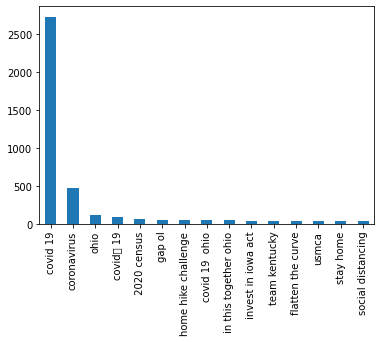

In [0]:
tweets['Segmented#'].value_counts()[:15].plot(kind = 'bar')

In [0]:
#Frequency of words
fdist = FreqDist(tweets['Segmented#'])


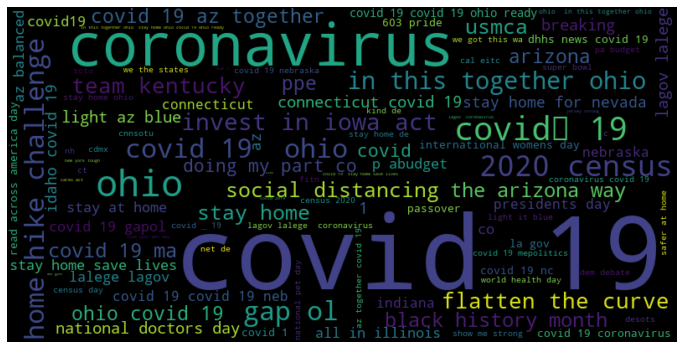

In [0]:
#WordCloud
wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(fdist)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
from ekphrasis.classes.spellcorrect import SpellCorrector
sp = SpellCorrector(corpus="twitter") 
for i in range(len(tweets['tweet_text'])):
  listToStr = ' '.join([str(elem) for elem in tweets['tweet_text'][i]])
  tweets.loc[i,'tweet_text_spell'] = sp.correct(listToStr)
  


Reading twitter - 1grams ...


KeyboardInterrupt: ignored